In [2]:
import pandas as pd
import numpy as np
import networkx as nx

from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import csr_matrix

import matplotlib.pyplot as plt

from tqdm import tqdm # progress bar

In [3]:
movies = pd.read_csv("data/movies.csv")
movies.head(10)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
5,6,Heat (1995),Action|Crime|Thriller
6,7,Sabrina (1995),Comedy|Romance
7,8,Tom and Huck (1995),Adventure|Children
8,9,Sudden Death (1995),Action
9,10,GoldenEye (1995),Action|Adventure|Thriller


In [4]:
ratings = pd.read_csv("data/ratings.csv")
ratings.head(10)

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
5,1,70,3.0,964982400
6,1,101,5.0,964980868
7,1,110,4.0,964982176
8,1,151,5.0,964984041
9,1,157,5.0,964984100


In [5]:
ratings['rating'] = ratings['rating'] - 2.5

## Dealing with Duplicate Data

In [6]:
duplicates = movies[movies.duplicated(subset=['title'], keep=False)]
sorted_duplicates = pd.DataFrame(duplicates.sort_values("title"))

sorted_duplicates

,movieId,title,genres
4169,6003,Confessions of a Dangerous Mind (2002),Comedy|Crime|Drama|Thriller
9106,144606,Confessions of a Dangerous Mind (2002),Comedy|Crime|Drama|Romance|Thriller
650,838,Emma (1996),Comedy|Drama|Romance
5601,26958,Emma (1996),Romance
5854,32600,Eros (2004),Drama
9135,147002,Eros (2004),Drama|Romance
2141,2851,Saturn 3 (1980),Adventure|Sci-Fi|Thriller
9468,168358,Saturn 3 (1980),Sci-Fi|Thriller
5931,34048,War of the Worlds (2005),Action|Adventure|Sci-Fi|Thriller
6932,64997,War of the Worlds (2005),Action|Sci-Fi


In [7]:
duplicateIds = [6003, 26958, 32600, 168358, 64997]
movies = movies[~movies["movieId"].isin(duplicateIds)]

## Graphing a Random Sample Network:

In [8]:
merged_ratings = pd.merge(ratings, movies, on='movieId', how='inner')

In [9]:
movies_count = merged_ratings.groupby('movieId')['userId'].agg(['count', 'nunique'])
print('Number of movies:', movies_count.shape)
# Filter on movies that have more than 5 ratings
movies_count = movies_count.query('count > 5')
print('Number of movies:', movies_count.shape)

display(movies_count.head(10))

merged_ratings =  merged_ratings[merged_ratings['movieId'].isin(movies_count.index)]

Number of movies: (9719, 2)
Number of movies: (3267, 2)


,count,nunique
movieId,,
1,215,215
2,110,110
3,52,52
4,7,7
5,49,49
6,102,102
7,54,54
8,8,8
9,16,16


In [10]:
np.random.seed(123)
random_indices = np.random.randint(0, len(merged_ratings), 500)
random_ratings = merged_ratings.iloc[random_indices]

In [11]:
G = nx.Graph()

In [12]:
user_nodes = set(random_ratings["userId"])
movie_nodes = set(random_ratings["title"])
edges = [(int(row['userId']), (row['title'])) for _, row in random_ratings.iterrows()]

G.add_nodes_from(user_nodes, bipartite=0, color ="red")
G.add_nodes_from(movie_nodes, bipartite=1, color = "blue")
G.add_edges_from(edges)

In [13]:
largest_cc = max(nx.connected_components(G), key=len)
subgraph = G.subgraph(largest_cc)

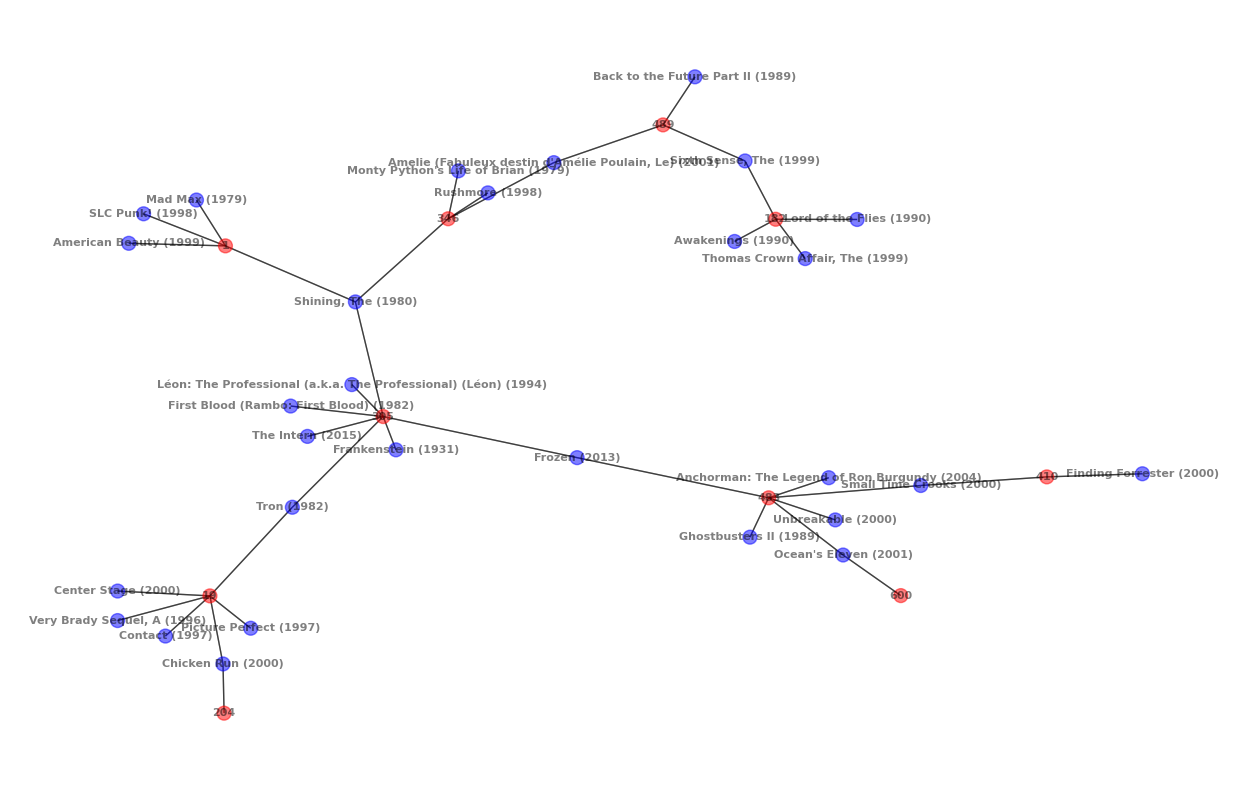

In [14]:
fig, ax = plt.subplots(figsize=(16, 10))

pos = nx.spring_layout(subgraph, seed=42, scale=2)  # Adjust the 'scale' parameter to spread out the graph

# Set node colors
node_colors = [subgraph.nodes[node]['color'] for node in subgraph.nodes]

# Draw the subgraph with smaller nodes, smaller text, and visible edges
nx.draw(subgraph, pos, with_labels=True, font_size=8, font_weight='bold', node_color=node_colors, node_size=100, alpha=0.5)

# Draw edges separately to make them more visible
nx.draw_networkx_edges(subgraph, pos, width=1.0, alpha=0.5)

plt.show()

## Colaborative Filtering Matrix

In [15]:
merged_ratings = pd.merge(ratings, movies, on='movieId', how='inner')

# Drop not popular movies
merged_ratings =  merged_ratings[merged_ratings['movieId'].isin(movies_count.index)]

sparse_collabfitering = merged_ratings.pivot(index = "title", columns = "userId", values = "rating")
display(sparse_collabfitering.head(10))

sparse_collabfitering.shape

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
title,,,,,,,,,,,,,,,,,,,,,
"'burbs, The (1989)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
(500) Days of Summer (2009),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
*batteries not included (1987),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10 Cloverfield Lane (2016),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.5
10 Things I Hate About You (1999),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.5,NaN,2.5,NaN,NaN,NaN,NaN,NaN
"10,000 BC (2008)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
101 Dalmatians (1996),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1.5,NaN,0.5,NaN,NaN,NaN,NaN,NaN
101 Dalmatians (One Hundred and One Dalmatians) (1961),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
102 Dalmatians (2000),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.5,NaN,NaN,NaN,NaN,NaN


(3267, 610)

In [16]:
sparse_matrix = csr_matrix(sparse_collabfitering)

In [17]:
n = len(sparse_collabfitering)
movie_similarity = np.zeros((n, n))

In [18]:
refresh_matrix = True
if refresh_matrix:
    for i in tqdm(range(n)):
        movies1_user = sparse_collabfitering.iloc[i, :].notna().to_numpy()
        
        for k in range(i+1, n):
            movies2_user = sparse_collabfitering.iloc[k, :].notna().to_numpy()

            # Calculate intersection using bitwise AND
            intersection_index = movies1_user & movies2_user

            # Check if there are common users
            if np.sum(intersection_index) >= 10:
                common_users = sparse_collabfitering.iloc[i, intersection_index].values
                other_movies = sparse_collabfitering.iloc[k, intersection_index].values
                
                movie_similarity[i, k] = cosine_similarity(common_users.reshape(1, -1), other_movies.reshape(1, -1))[0, 0]
                movie_similarity[k, i] = movie_similarity[i, k]

    movie_simDF = pd.DataFrame(movie_similarity, columns= sparse_collabfitering.index, index= sparse_collabfitering.index)
    movie_simDF.head(20)
    movie_simDF.to_csv("MtM_similarityMatrix.csv")

else:
    movie_similarity = pd.read_csv("MtM_similarityMatrix.csv", index_col=0)

100%|██████████| 3267/3267 [10:20<00:00,  5.26it/s] 


Our cosine similarities are between 0 and 1 becasue ratings can only be positive

In [121]:
threshold = 0.85

movie_similarity_thresholded = np.where(movie_similarity > threshold, 1, 0)
movie_similarity_thresholded= pd.DataFrame(movie_similarity_thresholded)

In [122]:
G = nx.from_pandas_adjacency(movie_similarity_thresholded)
print(f"Total Edges: {len(G.edges())}")

Total Edges: 51909


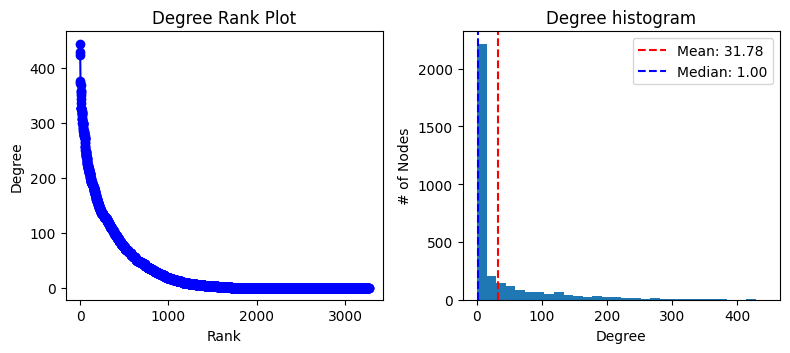

In [123]:
degree_sequence = sorted((d for n, d in G.degree()), reverse=True)
dmax = max(degree_sequence)

fig = plt.figure("Degree of a random graph", figsize=(8, 8))
# Create a gridspec for adding subplots of different sizes
axgrid = fig.add_gridspec(5, 4)

ax1 = fig.add_subplot(axgrid[3:, :2])
ax1.plot(degree_sequence, "b-", marker="o")
ax1.set_title("Degree Rank Plot")
ax1.set_ylabel("Degree")
ax1.set_xlabel("Rank")

ax2 = fig.add_subplot(axgrid[3:, 2:])
ax2.hist(degree_sequence, bins=30)
ax2.set_title("Degree histogram")
ax2.set_xlabel("Degree")
ax2.set_ylabel("# of Nodes")

mean_degree = np.mean(degree_sequence)
median_degree = np.median(degree_sequence)

# Plot mean and median as vertical lines
ax2.axvline(x=mean_degree, color='red', linestyle='--', label=f'Mean: {mean_degree:.2f}')
ax2.axvline(x=median_degree, color='blue', linestyle='--', label=f'Median: {median_degree:.2f}')
ax2.legend()

fig.tight_layout()
plt.show()

In [124]:
def plot_degree_histogram(g, normalized=True):
    print("Creating histogram...")
    aux_y = nx.degree_histogram(g)
    
    aux_x = np.arange(0,len(aux_y)).tolist()
    
    n_nodes = g.number_of_nodes()
    
    if normalized:
        for i in range(len(aux_y)):
            aux_y[i] = aux_y[i]/n_nodes
    
    return aux_x, aux_y

Creating histogram...


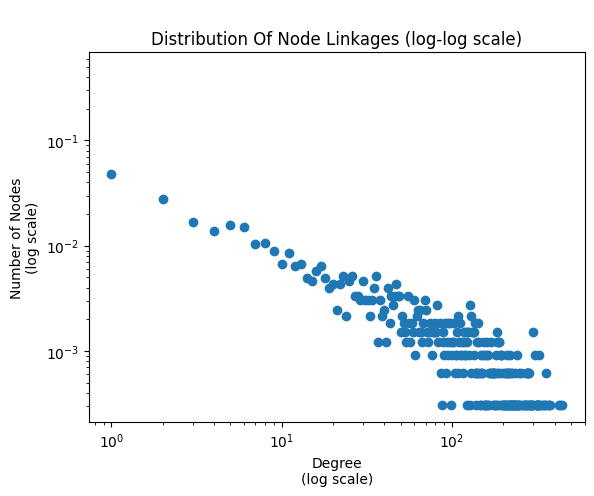

In [125]:
aux_x, aux_y = plot_degree_histogram(G, normalized=True)

plt.title('\nDistribution Of Node Linkages (log-log scale)')
plt.xlabel('Degree\n(log scale)')
plt.ylabel('Number of Nodes\n(log scale)')
plt.xscale("log")
plt.yscale("log")
plt.plot(aux_x, aux_y, 'o')
plt.show()

In [126]:
largest_cc = max(nx.connected_components(G), key=len)
subgraph = G.subgraph(largest_cc)

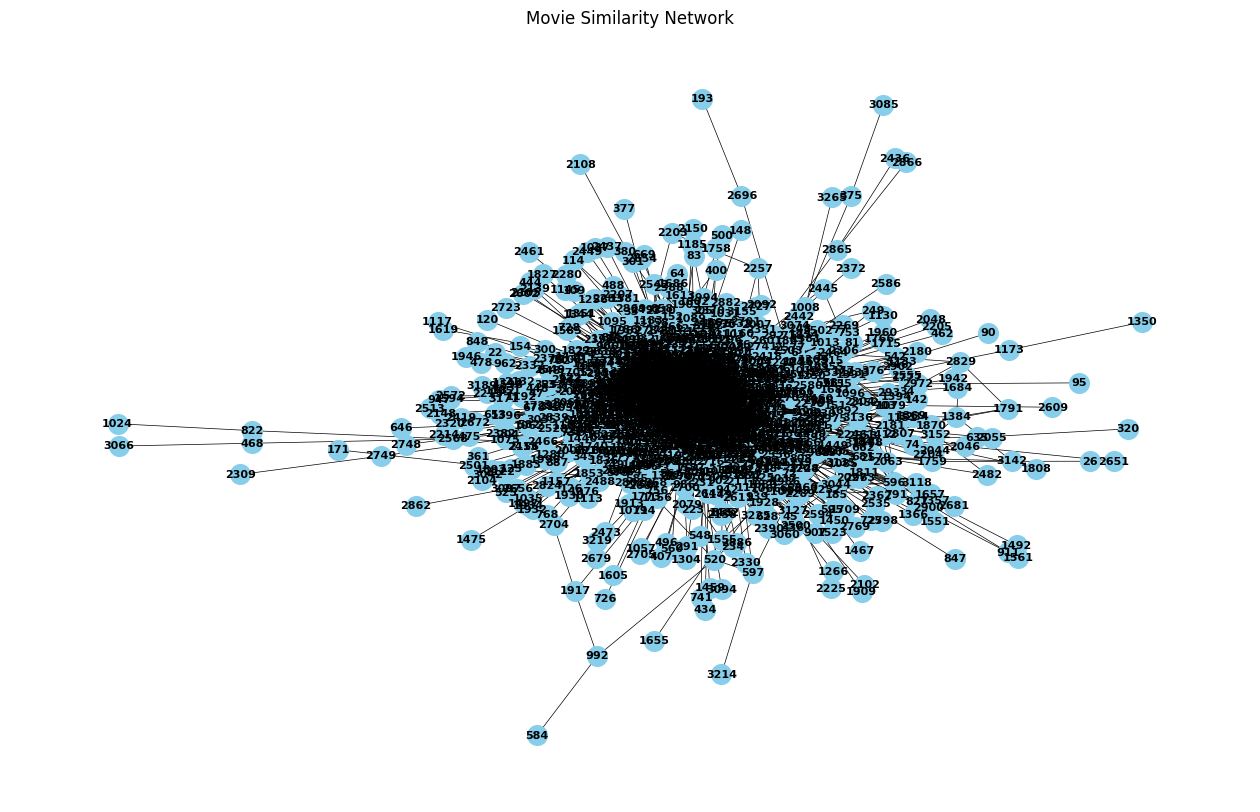

In [127]:
fig, ax = plt.subplots(figsize=(16, 10))
pos = nx.spring_layout(subgraph)

nx.draw(subgraph, pos, with_labels=True, font_weight='bold', node_size=200, node_color='skyblue', font_color='black', font_size=8, edge_color='black', width=0.5)

plt.title("Movie Similarity Network")
plt.show()

# Community detection

In [ ]:
#!pip install communities

In [155]:
communities = nx.community.greedy_modularity_communities(subgraph, resolution=1.2)
print(f'Number of communities: {len(communities)}')

keep_communities = []
for i, com in enumerate(communities):
    print(f'Community {i}: {len(com)}')
    if len(com) > 10 and i < 4:
        keep_communities.append(com)

print(f'\nModularity: {nx.community.modularity(subgraph, communities)}')

Number of communities: 20
Community 0: 551
Community 1: 501
Community 2: 349
Community 3: 151
Community 4: 51
Community 5: 40
Community 6: 11
Community 7: 7
Community 8: 5
Community 9: 5
Community 10: 3
Community 11: 3
Community 12: 3
Community 13: 3
Community 14: 3
Community 15: 2
Community 16: 2
Community 17: 2
Community 18: 1
Community 19: 1

Modularity: 0.21573281482859297


In [156]:
colors = ['red', 'blue', 'orange', 'green']
node_colors_assignment = {}
for i, nodes in enumerate(keep_communities):
    for node in nodes:
        node_colors_assignment[node] = colors[i]

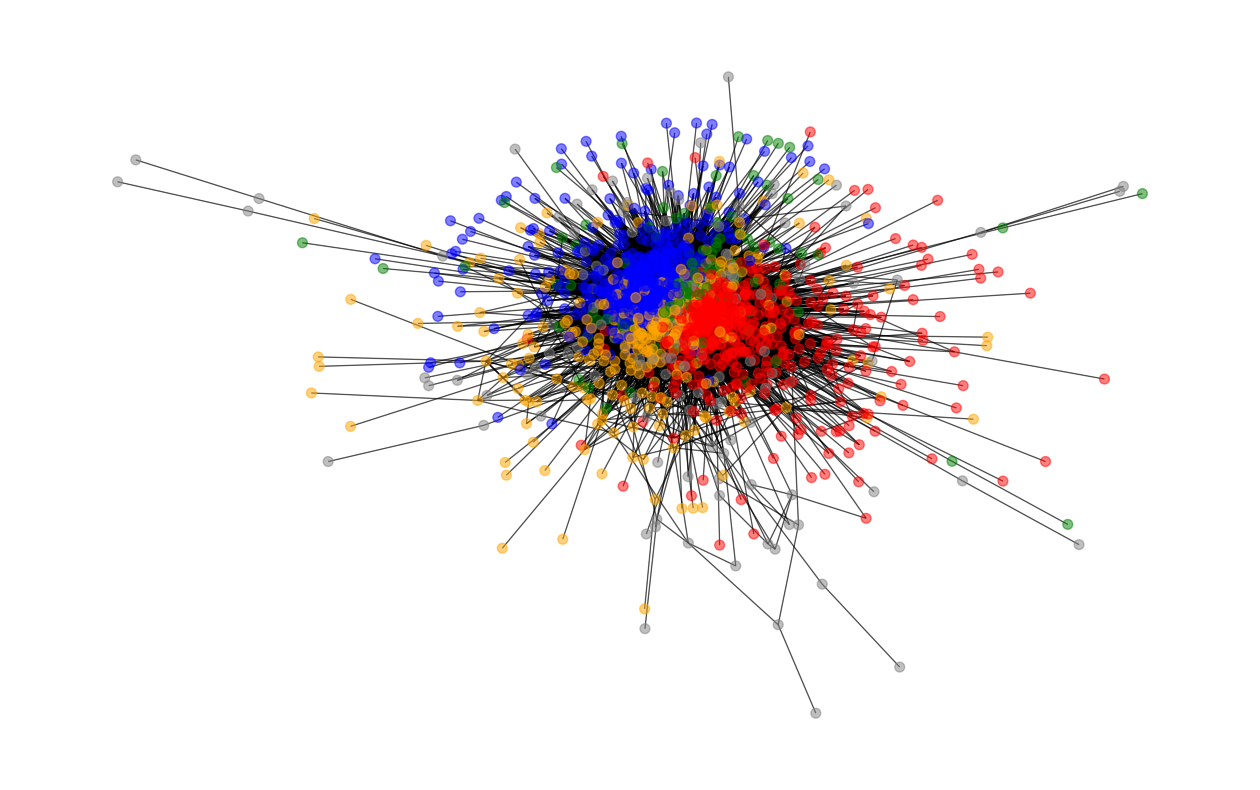

In [157]:
# Given subgraph and its communities
fig, ax = plt.subplots(figsize=(16, 10))

pos = nx.spring_layout(subgraph, seed=42, scale=1)  # Adjust the 'scale' parameter to spread out the graph

# Map node communities to colors
node_colors = [ node_colors_assignment[node] if node in node_colors_assignment else 'grey' for node in subgraph.nodes]

# Draw the subgraph with smaller nodes, smaller text, and visible edges
nx.draw(subgraph, pos, node_color=node_colors, node_size=50, alpha=0.5)

# Draw edges separately to make them more visible
nx.draw_networkx_edges(subgraph, pos, width=0.5, alpha=0.5)

plt.show()

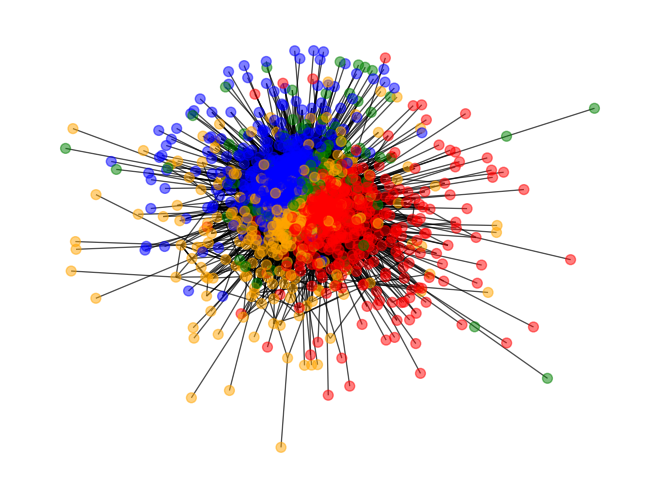

In [158]:
# Generate a layout for the graph
pos = nx.spring_layout(subgraph, seed=42, scale=20)

# Filter nodes that have a color assignment
filtered_nodes = [node for node in subgraph.nodes if node in node_colors_assignment]

# Map node communities to colors
node_colors = [node_colors_assignment[node] for node in filtered_nodes]

# Draw the nodes
nx.draw(subgraph.subgraph(filtered_nodes), pos, node_color=node_colors, node_size=50, alpha=0.5)

# Draw edges separately to make them more visible
nx.draw_networkx_edges(subgraph.subgraph(filtered_nodes), pos, width=0.5, alpha=0.5)

plt.show()

In [160]:
from communities.algorithms import louvain_method

communities, _ = louvain_method(np.array(movie_similarity_thresholded))
# >>> [{0, 1, 2}, {3, 4, 5}]